# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [32]:
from pprint import pformat as pf, pprint as pp
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(3)

from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://ipykernel.pylab.backend_inline
0.10.2
1.17.4
0.25.3


# Fetch Data

In [ ]:
url = 'http://192.168.0.156:8000/metrics?from=300'
response = requests.get(url)

In [4]:
#status_code = response.status_code
status_code = 404
if status_code == 200:
    print("web")
    data = json.loads(response.content.decode('utf-8'))
else:
    print("local")
    with open('sample.json', 'r') as f:
        data = json.load(f)


local


# Tidy Data

In [5]:
df = pd.DataFrame(data)
df

,id,metric,ts,value
0,498459,temperature,1.570597e+09,24.600000
1,498460,humidity,1.570597e+09,60.299999
2,498457,temperature,1.570597e+09,24.600000
3,498458,humidity,1.570597e+09,60.299999
4,498455,temperature,1.570597e+09,24.600000
...,...,...,...,...
206465,291996,humidity,1.569993e+09,61.799999
206466,291993,temperature,1.569993e+09,25.600000
206467,291994,humidity,1.569993e+09,61.799999
206468,291991,temperature,1.569993e+09,25.600000


In [6]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df

,id,metric,ts,value
0,498459,temperature,2019-10-09 05:02:49.808440924,24.600000
1,498460,humidity,2019-10-09 05:02:49.808440924,60.299999
2,498457,temperature,2019-10-09 05:02:41.699953079,24.600000
3,498458,humidity,2019-10-09 05:02:41.699953079,60.299999
4,498455,temperature,2019-10-09 05:02:36.119760036,24.600000
...,...,...,...,...
206465,291996,humidity,2019-10-02 05:08:03.949400902,61.799999
206466,291993,temperature,2019-10-02 05:07:58.392137051,25.600000
206467,291994,humidity,2019-10-02 05:07:58.392137051,61.799999
206468,291991,temperature,2019-10-02 05:07:52.811564922,25.600000


In [7]:
df = df.set_index('ts')
df

,id,metric,value
ts,,,
2019-10-09 05:02:49.808440924,498459,temperature,24.600000
2019-10-09 05:02:49.808440924,498460,humidity,60.299999
2019-10-09 05:02:41.699953079,498457,temperature,24.600000
2019-10-09 05:02:41.699953079,498458,humidity,60.299999
2019-10-09 05:02:36.119760036,498455,temperature,24.600000
...,...,...,...
2019-10-02 05:08:03.949400902,291996,humidity,61.799999
2019-10-02 05:07:58.392137051,291993,temperature,25.600000
2019-10-02 05:07:58.392137051,291994,humidity,61.799999


In [8]:
df = df.dropna()
df_temp = df[df['metric'] == 'temperature'][['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-10-02 05:00:00', '2019-10-02 06:00:00',
               '2019-10-02 07:00:00', '2019-10-02 08:00:00',
               '2019-10-02 09:00:00', '2019-10-02 10:00:00',
               '2019-10-02 11:00:00', '2019-10-02 12:00:00',
               '2019-10-02 13:00:00', '2019-10-02 14:00:00',
               ...
               '2019-10-08 20:00:00', '2019-10-08 21:00:00',
               '2019-10-08 22:00:00', '2019-10-08 23:00:00',
               '2019-10-09 00:00:00', '2019-10-09 01:00:00',
               '2019-10-09 02:00:00', '2019-10-09 03:00:00',
               '2019-10-09 04:00:00', '2019-10-09 05:00:00'],
              dtype='datetime64[ns]', name='ts', length=169, freq='H')

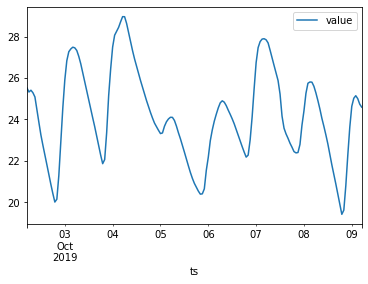

In [9]:
df_temp.plot()

# Differencing

In [26]:
df_diff = df_temp.diff().dropna()

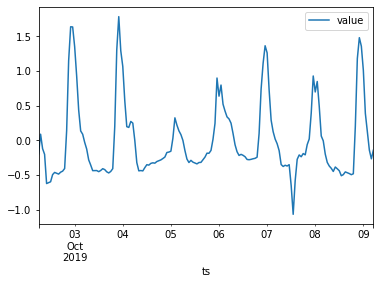

In [27]:
df_diff.plot()

# Stationarity Tests
## Augmented Dickey-Fuller Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

> Null Hypothesis (H0): Time Series is NOT stationary. 

**adf**: `float`

Test statistic

**pvalue**: `float`

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

**usedlag**: `int`

Number of lags used

**nobs**: `int`

Number of observations used for the ADF regression and calculation of the critical values

**critical values**: `dict`

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

**icbest**: `float`
The maximized information criterion if autolag is not None.

In [30]:
print("TEMPERATURE")
results = stattools.adfuller(df_temp['value'])

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

TEMPERATURE
p-value: 0.0002461217734312248
Reject H0. Reject non-stationary. It could be stationary.


In [31]:
print("DIFFERENCED")
results = stattools.adfuller(df_diff['value'])

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

DIFFERENCED
p-value: 7.172220353904693e-08
Reject H0. Reject non-stationary. It could be stationary.


# Auto Correlation Plots

In [15]:
df_acf = pd.DataFrame(stattools.acf(df_temp.dropna(), fft=True))

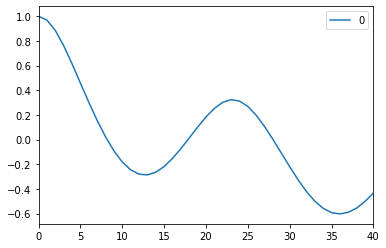

In [16]:
df_acf.plot()

In [17]:
df_pacf = pd.DataFrame(stattools.pacf(df_temp.dropna(), method='ols-inefficient'))

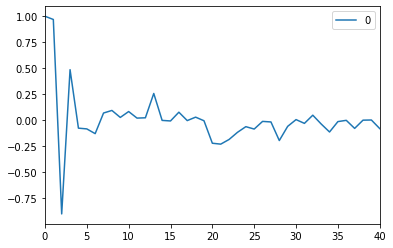

In [18]:
df_pacf.plot()

In [19]:
df_pacf[:6]

,0
0,1.000000
1,0.968942
2,-0.904331
3,0.485297
4,-0.078144
5,-0.085320


## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# ARIMA

In [60]:
df_temp.to_csv("data.csv")

In [61]:
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00', '2019-09-22 08:00:00',
               '2019-09-22 09:00:00', '2019-09-22 10:00:00',
               '2019-09-22 11:00:00', '2019-09-22 12:00:00',
               '2019-09-22 13:00:00', '2019-09-22 14:00:00',
               '2019-09-22 15:00:00', '2019-09-22 16:00:00',
               ...
               '2019-11-26 01:00:00', '2019-11-26 02:00:00',
               '2019-11-26 03:00:00', '2019-11-26 04:00:00',
               '2019-11-26 05:00:00', '2019-11-26 06:00:00',
               '2019-11-26 07:00:00', '2019-11-26 08:00:00',
               '2019-11-26 09:00:00', '2019-11-26 10:00:00'],
              dtype='datetime64[ns]', name='ts', length=1564, freq='H')

In [49]:
model = ARIMA(df_temp['value'].dropna(), (2,1,1)).fit()

In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                  168
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  34.041
Method:                       css-mle   S.D. of innovations              0.196
Date:                Wed, 27 Nov 2019   AIC                            -58.083
Time:                        14:24:49   BIC                            -42.463
Sample:                    10-02-2019   HQIC                           -51.743
                         - 10-09-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0110      0.083     -0.132      0.895      -0.174       0.152
ar.L1.D.value     1.4197      0.095     14.986      0.000       1.234       1.605
ar.L2.D.value    -0.6051      0.088     -6.843      0.000      -0.778      -0.432
ma.L1.D.value     0.0290      0.119      0.244      0.807      -0.204       0.261
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1731           -0.5258j            1.2855           -0.0671
AR.2            1.1731           +0.5258j            1.2855            0.0671
MA.1          -34.5374           +0.0000j           34.5374            0.5000
-----------------------------------------------------------------------------
"""

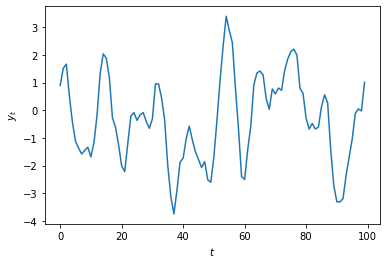

In [51]:
# Set coefficients
ar_coefs = [1, -1.4197, 0.6051]
ma_coefs = [1, 0.0290]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, sigma=0.5, )

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()

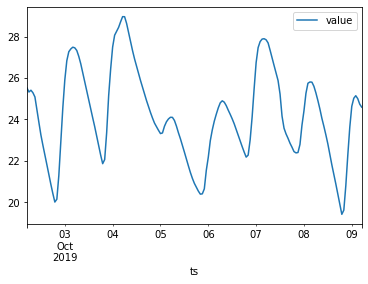

In [52]:
df_temp.plot()